In [1]:
!pip install uproot awkward 
from uproot_io import Events, View
import numpy as np
import matplotlib.pyplot as plt
import features as u

cheated_0 = Events('CheatedRecoFile_0.root')

# we have 499617 events in cheated_0

  Using cached uproot-5.5.1-py3-none-any.whl.metadata (33 kB)
  Using cached awkward-2.7.1-py3-none-any.whl.metadata (7.0 kB)
  Using cached cramjam-2.9.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.9 kB)
  Using cached awkward_cpp-42-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.1 kB)
Using cached uproot-5.5.1-py3-none-any.whl (362 kB)
Using cached awkward-2.7.1-py3-none-any.whl (863 kB)
Using cached awkward_cpp-42-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (637 kB)
Using cached cramjam-2.9.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.4 MB)


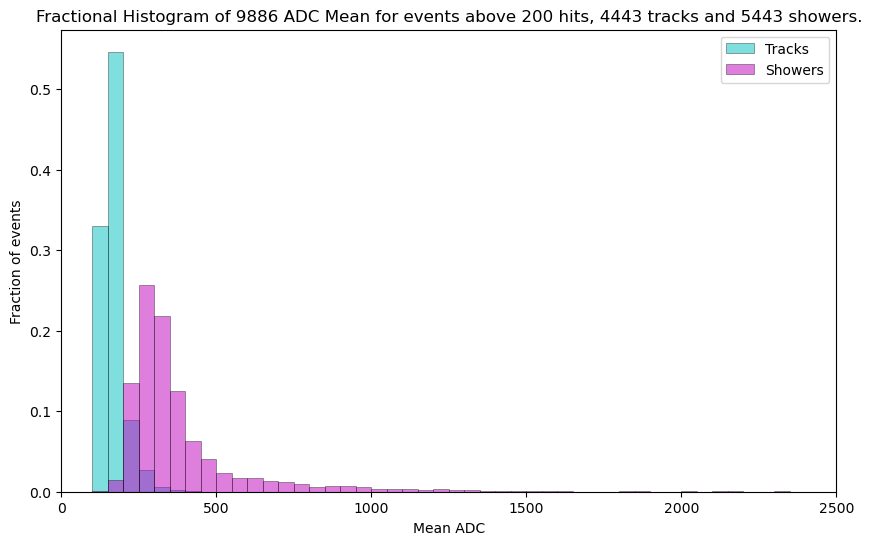

In [6]:
def var_adc_mean(events, start_idx, end_idx, hits_cutoff, show_plot=False):
    if not isinstance(start_idx, int) or not isinstance(end_idx, int) or start_idx < 0 or end_idx < 0 or start_idx > end_idx:
        return print('invalid entry of indices')

    avg_array_track = []
    avg_array_shower = []
    # loop over all idx
    for event_idx in range(start_idx, end_idx + 1):

        w_hits = events.reco_hits_w[event_idx]
        if len(w_hits) > hits_cutoff:
            
            adc_values = events.reco_adcs_w[event_idx]
            w_adc_avg = np.mean(adc_values)
        
            # filtering track or shower from pdg code
            pdg = events.mc_pdg[event_idx]
            shower = False # initialising the track or shower variable

            if pdg in [-11, 11, 22]:
                shower = True

            if shower:
                avg_array_shower.append(w_adc_avg)
            else: avg_array_track.append(w_adc_avg)

    # Manually get the fraction
    n_t = len(avg_array_track)
    n_s = len(avg_array_shower)
    
    # Define bin edges
    bin_edges = np.arange(0,2501,50)
    
    # Calculate fractional weights for each entry
    track_weights = np.ones_like(avg_array_track) / n_t if n_t > 0 else np.zeros_like(avg_array_track)
    shower_weights = np.ones_like(avg_array_shower) / n_s if n_s > 0 else np.zeros_like(avg_array_shower)

    # Calculate histogram bin heights (fractional values) and store them in arrays
    track_bin_heights, _ = np.histogram(avg_array_track, bins=bin_edges, weights=track_weights)
    shower_bin_heights, _ = np.histogram(avg_array_shower, bins=bin_edges, weights=shower_weights)

    # Plot the histogram with fractional bin heights
    plt.figure(figsize=(10, 6))
    plt.hist(avg_array_track, bins=bin_edges, weights=track_weights, color='c', edgecolor='k', linewidth=0.5, alpha=0.5, label='Tracks')
    plt.hist(avg_array_shower, bins=bin_edges, weights=shower_weights, color='m', edgecolor='k', linewidth=0.5, alpha=0.5, label='Showers')

    # Set plot details
    plt.title(f'Fractional Histogram of {n_t + n_s} ADC Mean for events above {hits_cutoff} hits, {n_t} tracks and {n_s} showers.')
    plt.xlabel('Mean ADC')
    plt.ylabel('Fraction of events')
    plt.xlim(0, 2500)
    plt.legend()
    plt.grid(False)
    if show_plot:
        plt.show()

    return track_bin_heights, shower_bin_heights

training_data_example = var_adc_mean(cheated_0, 0, 499000, 200, True)

[0.32995233, 0.00036744442]


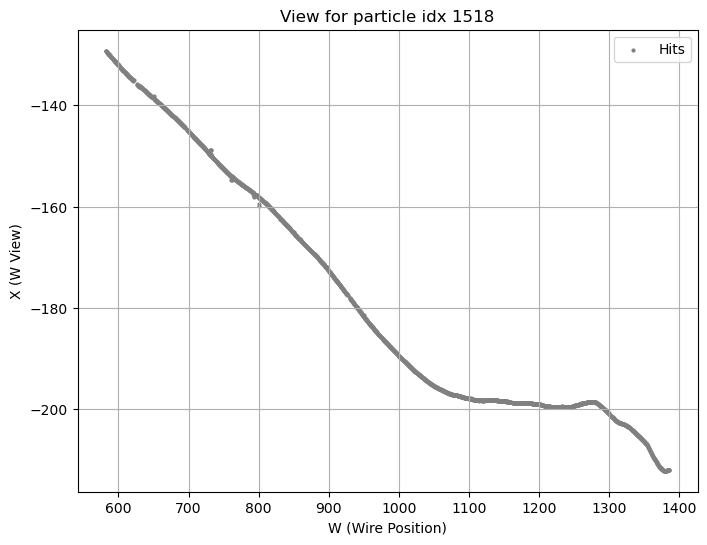

In [11]:
# if we now look at cheated 10 again to pretend its our data:
cheated_10 = Events("CheatedRecoFile_10.root")

def p_adc_mean(training_data, testing_events, event_idx):
    pdf_t, pdf_s = training_data
    bin_edges = np.linspace(0,2500,51)

    adc_values = testing_events.reco_adcs_w[event_idx]
    w_adc_avg = np.mean(adc_values)

    p_idx = np.searchsorted(bin_edges, w_adc_avg) - 1

    p_t = pdf_t[p_idx]
    p_s = pdf_s[p_idx]

    return p_t, p_s

print(p_adc_mean(training_data_example, cheated_10, 1518)) # example that the rms gives as inconclusive, but here we can see the adc_max gives track.
u.plot_idx(cheated_10, 1518)